In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [54]:
path = "logs/sub-m04/m04_prl_DecideNet_pun.csv"
df = pd.read_csv(path)
df.head()

,block,rwd,magn_left,magn_right,onset_iti_plan,onset_isi_plan,onset_dec_plan,onset_out_plan,.thisRepN,.thisTrialN,...,onset_out_glob,acc_after_trial,won_bool,won_magn,rt,response,subject_id,condition,group,Unnamed: 28
0,-1,-1,44,6,0.000000,7.490662,5.990662,11.824785,0,0,...,45.315545,1300,False,0,1.0140286879141058,d,m04,pun,1,NaN
1,-1,-1,35,15,13.324785,20.861200,19.361200,27.303987,0,1,...,60.794369,1300,False,0,0.40607344270392787,d,m04,pun,1,NaN
2,-1,-1,17,33,28.803987,33.588177,32.088177,38.900853,0,2,...,72.390474,1300,False,0,0.4305663175509835,d,m04,pun,1,NaN
3,-1,1,44,6,40.400853,47.249944,45.749944,50.972279,0,3,...,84.456239,1294,True,6,0.8702626197555219,d,m04,pun,1,NaN
4,-1,-1,27,23,52.472279,58.825269,57.325269,62.997305,0,4,...,96.486658,1294,False,0,0.5122708122726181,d,m04,pun,1,NaN


### Processing of log dataframe

Each row of a dataframe represents *single trial*.
Description of useful dataframe columns:

Task characteristics:
- `block`: indicates which box is currently more likely to be rewarded / punished
- `rwd`: indicates which box is rewarded / punished on a given trial
- `magn_left` and `magn_right`: visible reward magnitudes

Subject responses:
- `response`: subject response
- `rt`: reaction time (max. 1.5 seconds)
- `won_bool`: indicates if subject won / not loose points
- `won_magn`: indicates number of points won / lost
- `acc_after_trial`: subject total points after given trial

In [55]:
# Convert subject responses to integers
df.loc[df['response'] == 'a', 'response'] = -1
df.loc[df['response'] == 'd', 'response'] = 1
try:
    df.loc[df['response'] == 'None', 'response'] = 0
except TypeError:
    print('No missing responses.')

# Convert reaction time to float
df['rt'] = pd.to_numeric(df['rt'], errors='coerce')

# Grab additional info
# N_trials = df.shape[0]
# N_blocks = 5                                                                  
info = {}
info['n_trials'] = df.shape[0]
info['n_blocks'] = 5 #TODO grab from data
info['condition'] = df['condition'][0]
info['subject'] = df['subject_id'][0]
info['group'] = df['group'][0]

# Reverse the punishing interpretation of columns in punishment condition 
# NOTE! 'block' and 'rwd' still have BEING CHOSEN interpretation
if info['condition'] == 'pun':
    df['won_magn'] *= (-1)  
    df['won_bool'] = ~ df['won_bool'] 
    df['magn_left'] *= (-1)
    df['magn_right'] *= (-1)
    
# Drop unnecessary columns
df = df[['block', 'rwd', 'magn_left', 'magn_right', 
         'response', 'rt',
         'won_bool', 'won_magn', 'acc_after_trial']]

df.head(10)

,block,rwd,magn_left,magn_right,response,rt,won_bool,won_magn,acc_after_trial
0,-1,-1,-44,-6,1,1.014029,True,0,1300
1,-1,-1,-35,-15,1,0.406073,True,0,1300
2,-1,-1,-17,-33,1,0.430566,True,0,1300
3,-1,1,-44,-6,1,0.870263,False,-6,1294
4,-1,-1,-27,-23,1,0.512271,True,0,1294
5,-1,-1,-10,-40,1,0.565789,True,0,1294
6,-1,-1,-25,-25,1,0.655367,True,0,1294
7,-1,-1,-18,-32,1,0.886026,True,0,1294
8,-1,1,-34,-16,1,0.446374,False,-16,1278
9,-1,-1,-21,-29,1,0.515319,True,0,1278


### Visualisation of subject responses

In [163]:
col_blu = tuple([val/255 for val in [86, 180, 233]]) #right
col_blu_d = tuple([val/255 for val in [11, 58, 84]])
col_yel = tuple([val/255 for val in [240, 228, 66]]) #left

# Determine begin and end of the blocks and rewarded side
blocks = np.zeros((2, N_blocks+1), dtype='int')
blocks[0, 0:N_blocks] = np.nonzero(df['block'].diff() != 0)[0] + 1
blocks[0, N_blocks] = N_trials
blocks[1, 0:N_blocks] = df.loc[blocks[0], 'block'][:-1]
blocks

array([[  1,  21,  43,  64,  89, 110],
       [  1,  -1,   1,  -1,   1,   0]])

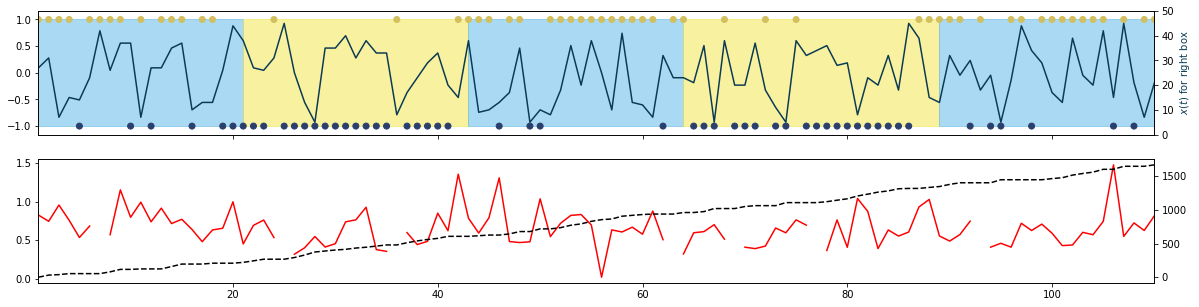

In [178]:
x_trials = np.arange(1, df.shape[0]+1)

fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, 
    figsize=(20, 5), facecolor='w')

### Upper subplot ###########################################################

# True reward contingencies
for i in range(N_blocks):
    
    if blocks[1, i] == -1:  col = col_yel
    else:                   col = col_blu
        
    ax1.fill_between(
        x=[blocks[0, i], blocks[0, i+1]], 
        y1=-1, y2=1, 
        color=col, alpha=.5)
    
ax1.scatter(x_trials, df.rwd, c=df.rwd, cmap='cividis', vmin=-1.5, vmax=1.5)

ax1b = ax1.twinx()

ax1b.plot(x_trials, df['magn_right'], color=col_blu_d)
ax1b.set_ylabel('$x(t)$ for right box', color=col_blu_d)
ax1b.set_ylim(0, 50)
ax1b.set_xlim(1, N_trials)


### Lower subplot ###########################################################
ax2.plot(x_trials, pd.to_numeric(df['rt'], errors='coerce'), 'r')

ax2b = ax2.twinx()
ax2b.plot(x_trials, df.acc_after_trial, 'k--')


### Behavioral modelling

#### Assumptions:

- experienced utility is proportional to displayed reward magnitude: 
$$u(x) = x$$
- values (reflecting beliefs about probability) are learned with simple delta learning rule (TD model):
$$V(a_t)=V(a_{t-1})+ \alpha [R-V(a_{t-i})]$$
- choice probabilites are computed with degenerate softmax with infinitely high inverse temperature (parsimoneous approach introduced by *Summerfield et al. 2011*):
$$p(a)=\frac{V(a)}{V(a)+V(b)}$$

Free parameters:

- $\alpha \in [0, 0.5]$: learning rate (modelling learning rate above half would result in model selecting previously rewarded / not punished option which is not realistic 

Questions:

- simultaneous update of both values?


In [56]:
def estimate_values(df, alpha):
    '''Implements TD learning model on experienced probabilistic outcomes.
    
    Args:
        df (pd.Dataframe): clean behavioral responses
        alpha (float): learning rate 
        
    Returns:
        val (np.array): reflects algorithm trialwise beliefs about 
            probabilities that box will be rewarded / punished
    '''
    
    val = np.zeros((info['n_trials'], 2))
    val[0] = [.5, .5] # Initial beliefs (agnostic)

    for trial, rwd in df['rwd'][:-1].iteritems():
        val[trial+1, 1] = val[trial, 1] + alpha * ((rwd + 1)/2 - val[trial, 1])
        val[trial+1, 0] = val[trial, 0] + alpha * ((-rwd + 1)/2 - val[trial, 0])    

    return val

def estimate_utilities(df, gamma=1, delta=1):                                               
    '''Implements function converting reward magnitude to experienced utility.
    
    Args:
        df (pd.Dataframe): clean behavioral responses
        gamma (float): loss aversion parameter
        delta: (float): risk aversion parameter
        
    Returns:
        util (np.array): reflects algorithm trialwise estimates of utility 
            for both left and right boxes
    
    '''
    
    util = np.zeros((info['n_trials'], 2))
    
    if info['condition'] == 'pun': 
        factor = (-1) * gamma
    else:
        factor = 1
        
    util[:, 0] = factor * np.abs(df['magn_left'])
    util[:, 1] = factor * np.abs(df['magn_right'])

    return util

def estimate_choice_probability(df, val, util, kind='simple', theta=None):
    '''Implements softmax decision rule reflecting choice probabilities'''

    # Calculate expected value for both options
    ev = np.multiply(util, val)
    
    if kind == 'simple':
        p = ev / np.sum(ev, axis=1)[:, np.newaxis]
        if np.sum(ev) < 0: 
            p = np.fliplr(p)
        
    elif kind == 'softmax':
        p = np.exp(theta * ev) / np.sum(np.exp(theta * ev), axis=1)[:, np.newaxis]

    return p

def g_square(df, p):
    '''Calculate badness-of-fit quality measure. G-square is inversely 
    related to log likelyhood.'''

    ll = 0 

    for i, resp in df['response'].iteritems():

        if resp == -1:
            ll += np.log(p[i, 0])
        elif resp == 1:
            ll += np.log(p[i, 1])

    return (-2) * ll

### Behavioral Models #######################################################

def model1(df, alpha):
    '''Simple one-parameter model with variable learning rate.'''
    
    val = estimate_values(df, alpha)
    util = estimate_utilities(df)
    p = estimate_choice_probability(df, val, util, kind='simple')
    
    return g_square(df, p)
    
    
def model2(df, alpha, theta):
    '''Two-parameter model  with variable learning rate and inverse T.'''
    
    val = estimate_values(df, alpha)
    util = estimate_utilities(df)
    p = estimate_choice_probability(df, val, util, kind='softmax', theta=theta)
    
    return g_square(df, p)


### Show example model fit for models 1 and 2

/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


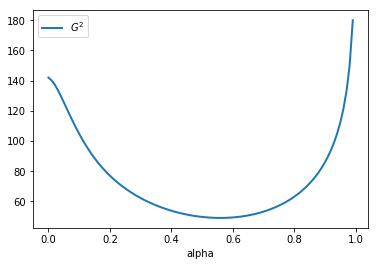

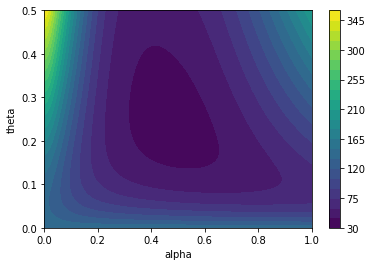

In [67]:
N_grid = 100

alpha = np.linspace(0, 1, N_grid)
theta = np.linspace(0, .5, N_grid)

# Model 1
fit1 = np.zeros(N_grid)

for i, a in enumerate(alpha):
    fit1[i] = model1(df, a)
    
fig1, ax1 = plt.subplots(facecolor='w')
ax1.plot(alpha, fit1, linewidth=2, label='$G^2$')
ax1.set_xlabel('alpha')
ax1.legend()

# Model 2
av, tv = np.meshgrid(alpha, theta)

fit2 = np.zeros((N_grid, N_grid))
for i, a in enumerate(alpha):
    for j, t in enumerate(theta):
        fit2[i, j] = model2(df, a, t)
        
fig2, ax2 = plt.subplots(facecolor='w')
im2 = ax2.contourf(alpha, theta, fit2.T, levels=30)
ax2.set_xlabel('alpha')
ax2.set_ylabel('theta')
fig.colorbar(im2, ax=ax2)